# **Proyecto para Ciencia e datos**


# **Auto:** Miguel Ángel Morán Flores

## **Objetivo general:** Analizar los factores que afectan el éxito comercial y de crítica de las películas, usando datos del portal TMDb.




---



# Bibliotecas

In [87]:
import os
import json
import pandas as pd
import numpy as np
import kagglehub
import ast
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Descarga de los datasets

In [ ]:
# DESCARGAR Y COPIAR DATOS

print("\n📥 Descargando dataset de Kaggle")
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")
print(f"✅ Dataset descargado en: {path}")

# Listar archivos disponibles en el directorio
print(f"\n📁 Archivos disponibles en el directorio origen:")
files = os.listdir(path)
for file in files:
    print(f"   - {file}")

destino = "../datalake/bronze"

# Copiar todos los archivos CSV
for archivo in os.listdir(path):
    if archivo.endswith(".csv"):
        src = os.path.join(path, archivo)
        dst = os.path.join(destino, archivo)
        shutil.copy(src, dst)
        print(f"✅ Copiado: {archivo} → {destino}")


📥 Descargando dataset de Kaggle...
✅ Dataset descargado en: C:\Users\mikes\.cache\kagglehub\datasets\tmdb\tmdb-movie-metadata\versions\2

📁 Archivos disponibles en el directorio:
   - tmdb_5000_credits.csv
   - tmdb_5000_movies.csv
✅ Copiado: tmdb_5000_credits.csv → ../datalake/bronze
✅ Copiado: tmdb_5000_movies.csv → ../datalake/bronze


In [11]:
print(f"\n📂 Usando archivos locales: {os.listdir(destino)}")
df_movies = pd.read_csv(os.path.join(destino, "tmdb_5000_movies.csv"))
df_credits = pd.read_csv(os.path.join(destino, "tmdb_5000_credits.csv"))


📂 Usando archivos locales: ['tmdb_5000_credits.csv', 'tmdb_5000_movies.csv']


# Analisamos el datasets de peliculas

In [12]:
print(f"\n📊 Shape del dataset: {df_movies.shape}")
print("-"*20)
print(f"Columnas originales: {df_movies.columns.tolist()}")
print("-"*20)
print(f"\nNumero de rows: {len(df_movies)}")
print("-"*20)
print(f"\n🔍 Primeras filas del dataset:")
print(df_movies.head(10))
print("-"*20)


📊 Shape del dataset: (4803, 20)
--------------------
Columnas originales: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']
--------------------

Numero de rows: 4803
--------------------

🔍 Primeras filas del dataset:
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
5  258000000  [{"id": 14, "name": "Fantasy"}, {"id": 28, "na...   
6  260000000  [{"id": 16, "name": "Animation"}, {"id": 10751...   
7  280000000

# Analisamos el dataset de creditos

In [13]:
print(f"\n📊 Shape del dataset: {df_credits.shape}")
print("-"*20)
print(f"Columnas originales: {df_credits.columns.tolist()}")
print("-"*20)
print(f"\nNumero de rows: {len(df_credits)}")
print("-"*20)
print(f"\n🔍 Primeras filas del dataset:")
print(df_credits.head(10))
print("-"*20)


📊 Shape del dataset: (4803, 4)
--------------------
Columnas originales: ['movie_id', 'title', 'cast', 'crew']
--------------------

Numero de rows: 4803
--------------------

🔍 Primeras filas del dataset:
   movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   
5       559                              Spider-Man 3   
6     38757                                   Tangled   
7     99861                   Avengers: Age of Ultron   
8       767    Harry Potter and the Half-Blood Prince   
9    209112        Batman v Superman: Dawn of Justice   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa... 

# Limpieza y transformación basica

In [14]:
# Renombramos la columna 'movie_id' para poder unir
df_credits.rename(columns={'movie_id': 'id'}, inplace=True)

In [15]:
# Unimos ambos datasets
df = df_movies.merge(df_credits, on='id')
print(df.shape)
df.head(10)

(4803, 23)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",..

In [16]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [17]:
# Convertir fecha y crear el año
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year

In [18]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew', 'year'],
      dtype='object')

In [19]:
df.count()

budget                  4803
genres                  4803
homepage                1712
id                      4803
keywords                4803
original_language       4803
original_title          4803
overview                4800
popularity              4803
production_companies    4803
production_countries    4803
release_date            4802
revenue                 4803
runtime                 4801
spoken_languages        4803
status                  4803
tagline                 3959
title_x                 4803
vote_average            4803
vote_count              4803
title_y                 4803
cast                    4803
crew                    4803
year                    4802
dtype: int64

In [20]:
# Filtramos registros válidos
df = df[(df['budget'] > 0) & (df['revenue'] > 0) & (df['year'].notna())]

In [21]:
df.count()

budget                  3229
genres                  3229
homepage                1347
id                      3229
keywords                3229
original_language       3229
original_title          3229
overview                3229
popularity              3229
production_companies    3229
production_countries    3229
release_date            3229
revenue                 3229
runtime                 3229
spoken_languages        3229
status                  3229
tagline                 2984
title_x                 3229
vote_average            3229
vote_count              3229
title_y                 3229
cast                    3229
crew                    3229
year                    3229
dtype: int64

In [22]:
# Extraer genero principal
def get_first_genre(genres):
    try:
        return ast.literal_eval(genres)[0]['name']
    except:
        return None

df['main_genre'] = df['genres'].apply(get_first_genre)

In [23]:
def get_director(crew):
    try:
        crew_list = ast.literal_eval(crew)
        for person in crew_list:
            if person['job'] == 'Director':
                return person['name']
    except:
        pass
    return None

df['director'] = df['crew'].apply(get_director)

In [24]:
def get_top_actors(cast):
    try:
        cast_list = ast.literal_eval(cast)
        return [actor['name'] for actor in cast_list[:3]]
    except:
        return []

df['top_actors'] = df['cast'].apply(get_top_actors)

In [25]:
# Crear variable objetivo
df['success'] = np.where(df['revenue'] > df['budget'], 1, 0)

In [26]:
print("✅ Quedandonos solo con las columnas que nos importan:")
cols = ['title_x', 'year', 'main_genre', 'director', 'top_actors',
        'budget', 'revenue', 'popularity', 'vote_average', 'runtime', 'success']
df = df[cols]
df.head()

✅ Quedandonos solo con las columnas que nos importan:


,title_x,year,main_genre,director,top_actors,budget,revenue,popularity,vote_average,runtime,success
0,Avatar,2009.0,Action,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",237000000,2787965087,150.437577,7.2,162.0,1
1,Pirates of the Caribbean: At World's End,2007.0,Adventure,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]",300000000,961000000,139.082615,6.9,169.0,1
2,Spectre,2015.0,Action,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",245000000,880674609,107.376788,6.3,148.0,1
3,The Dark Knight Rises,2012.0,Action,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]",250000000,1084939099,112.312950,7.6,165.0,1
4,John Carter,2012.0,Action,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",260000000,284139100,43.926995,6.1,132.0,1


In [34]:
df.to_csv('../datalake/gold/data.csv', index=False)

In [27]:
cols_num = ['budget', 'revenue', 'popularity', 'vote_average', 'runtime']
data_num = df[cols_num]
data_num.head()

,budget,revenue,popularity,vote_average,runtime
0,237000000,2787965087,150.437577,7.2,162.0
1,300000000,961000000,139.082615,6.9,169.0
2,245000000,880674609,107.376788,6.3,148.0
3,250000000,1084939099,112.312950,7.6,165.0
4,260000000,284139100,43.926995,6.1,132.0


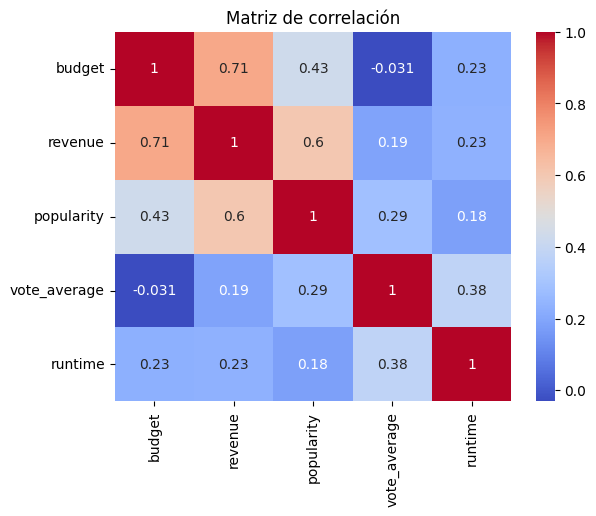

In [28]:
sns.heatmap(data_num.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

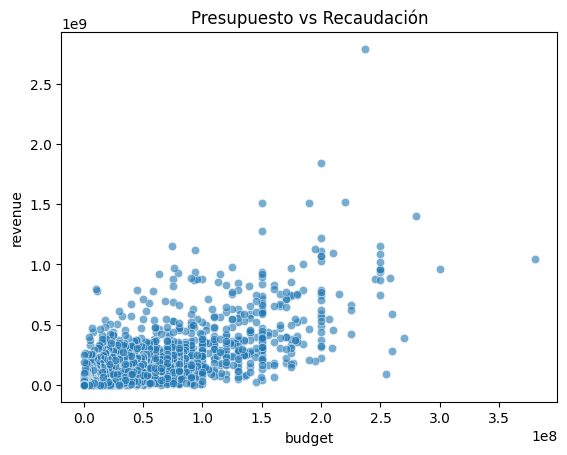

In [29]:
# Presupuesto vs Recaudación
sns.scatterplot(x='budget', y='revenue', data=df, alpha=0.6)
plt.title("Presupuesto vs Recaudación")
plt.show()

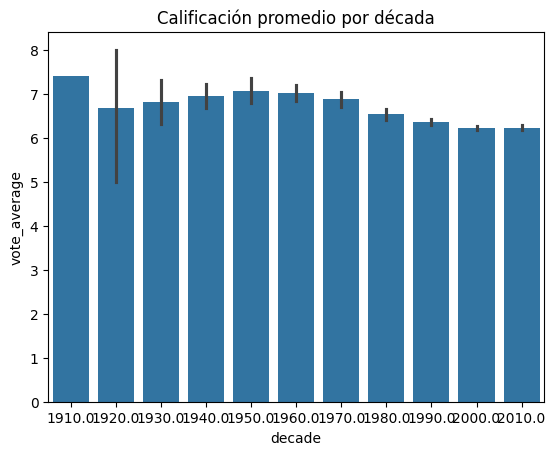

In [30]:
# Promedio de calificación por década
df['decade'] = (df['year'] // 10) * 10
sns.barplot(x='decade', y='vote_average', data=df)
plt.title("Calificación promedio por década")
plt.show()

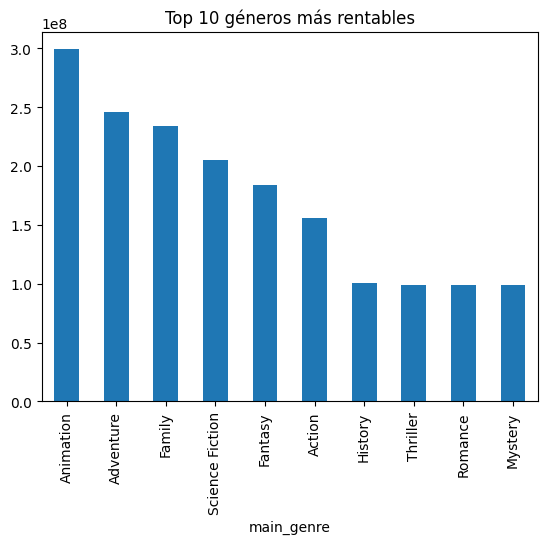

In [31]:
genre_revenue = df.groupby('main_genre')['revenue'].mean().sort_values(ascending=False).head(10)
genre_revenue.plot(kind='bar', title="Top 10 géneros más rentables")
plt.show()

# Clasificación: **“Éxito o fracaso”**

In [39]:
df.columns

Index(['title_x', 'year', 'main_genre', 'director', 'top_actors', 'budget',
       'revenue', 'popularity', 'vote_average', 'runtime', 'success',
       'decade'],
      dtype='object')

In [40]:
# Seleccionar variables
features = ['budget', 'popularity', 'vote_average', 'runtime', 'main_genre', 'director']
X = df[features]
y = df['success']

In [41]:
# Separar numéricas y categóricas
numeric_features = ['budget', 'popularity', 'vote_average', 'runtime']
categorical_features = ['main_genre', 'director']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [44]:
# Ajustar y transformar
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (2583, 1308)
y_train shape: (2583,)


In [46]:
def  build_baseline_model():
    """
    Modelo SIN regularización para demostrar overfitting
    CNN profunda con muchos parámetros
    """
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Clasificación binaria
    ])
    return model

baseline_model = build_baseline_model()
baseline_model.summary()

c:\Users\mikes\Documents\Maestria\DataScience\proyecto\env_ds_proy\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       167,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,921 (695.00 KB)

 Trainable params: 177,921 (695.00 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar modelo
history = baseline_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7456 - loss: 0.5316 - val_accuracy: 0.7740 - val_loss: 0.4679
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.4053 - val_accuracy: 0.7678 - val_loss: 0.4744
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8804 - loss: 0.2930 - val_accuracy: 0.7632 - val_loss: 0.5011
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9334 - loss: 0.1789 - val_accuracy: 0.7523 - val_loss: 0.6479
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9551 - loss: 0.1193 - val_accuracy: 0.7446 - val_loss: 0.7242
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.0812 - val_accuracy: 0.7523 - val_loss: 0.7987
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9787 - loss: 0.0608 - val_accuracy: 0.7384 - val_loss: 0.9538
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.0461 - val_accuracy: 0.7322 - v

In [208]:
test_loss_basica, test_acc_basica = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy baseline_model: {test_acc_basica:.4f}")


📊 Test Accuracy baseline_model: 0.7539


In [53]:
# Compila el modelo
baseline_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping ligero: espera 5 épocas sin mejora
early_stop_baseline = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entrena el modelo
history_baseline = baseline_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_baseline],
    verbose=1
)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9977 - loss: 0.0037 - val_accuracy: 0.7214 - val_loss: 2.0185
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy: 0.7368 - val_loss: 2.0808
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0028 - val_accuracy: 0.7322 - val_loss: 2.2030
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0069 - val_accuracy: 0.7229 - val_loss: 2.0212
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0029 - val_accuracy: 0.7353 - val_loss: 1.9867
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0028 - val_accuracy: 0.7276 - val_loss: 2.0351
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.7399 - val_loss: 2.0186
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.7384 - v

In [54]:
test_loss_basica, test_acc_basica = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy baseline_model earlystop: {test_acc_basica:.4f}")


📊 Test Accuracy baseline_model earlystop: 0.7245


In [81]:
# Guardar el modelo entrenado
baseline_model.save("../model/baseline_model.h5")

# Guardar el preprocesador (ColumnTransformer)
joblib.dump(preprocessor, "../model/preprocessor.pkl")

print("✅ Modelo y preprocesador guardados correctamente.")

✅ Modelo y preprocesador guardados correctamente.


In [ ]:
def build_dropout_model():
  model = models.Sequential([
      layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
      layers.Dropout(0.4),  # Apaga el 40% de las neuronas
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.4),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.4),
      layers.Dense(1, activation='sigmoid')  # Clasificación binaria
  ])
  return model

dropout_model = build_dropout_model()
dropout_model.summary()

c:\Users\mikes\Documents\Maestria\DataScience\proyecto\env_ds_proy\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       167,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,921 (695.00 KB)

 Trainable params: 177,921 (695.00 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compilación
dropout_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping ligero
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento
history_dropout = dropout_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7344 - loss: 0.5736 - val_accuracy: 0.7570 - val_loss: 0.4860
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7615 - loss: 0.4651 - val_accuracy: 0.7786 - val_loss: 0.4646
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7998 - loss: 0.4257 - val_accuracy: 0.7802 - val_loss: 0.4541
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8362 - loss: 0.3729 - val_accuracy: 0.7693 - val_loss: 0.4761
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.3152 - val_accuracy: 0.7570 - val_loss: 0.5180
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9125 - loss: 0.2414 - val_accuracy: 0.7632 - val_loss: 0.5681
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9241 - loss: 0.2016 - val_accuracy: 0.7570 - val_loss: 0.6373
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9307 - loss: 0.1774 - val_accuracy: 0.7539 - v

In [58]:
test_loss_basica, test_acc_basica = dropout_model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy dropout_model: {test_acc_basica:.4f}")


📊 Test Accuracy dropout_model: 0.7802


In [80]:
# Guardar el modelo entrenado
dropout_model.save("../model/dropout_model.h5")
print("✅ Modelo guardado correctamente.")

✅ Modelo guardado correctamente.


In [63]:
def build_l2_model():
  model = models.Sequential([
      layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),
                  kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(64, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(32, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1, activation='sigmoid')
  ])
  return model
l2_model = build_l2_model()
l2_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │       167,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,921 (695.00 KB)

 Trainable params: 177,921 (695.00 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compilación
l2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping ligero
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento
history_l2 = l2_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7460 - loss: 0.7024 - val_accuracy: 0.7740 - val_loss: 0.5678
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7983 - loss: 0.5081 - val_accuracy: 0.7879 - val_loss: 0.5179
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.4264 - val_accuracy: 0.7817 - val_loss: 0.5402
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.3490 - val_accuracy: 0.7740 - val_loss: 0.6229
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9350 - loss: 0.2770 - val_accuracy: 0.7755 - val_loss: 0.6687
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9454 - loss: 0.2282 - val_accuracy: 0.7740 - val_loss: 0.7078
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9605 - loss: 0.1987 - val_accuracy: 0.7616 - val_loss: 0.7600
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [65]:
test_loss_basica, test_acc_basica = l2_model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy l2_model: {test_acc_basica:.4f}")


📊 Test Accuracy l2_model: 0.7879


In [79]:
# Guardar el modelo entrenado
l2_model.save("../model/l2_model.h5")
print("✅ Modelo guardado correctamente.")

✅ Modelo guardado correctamente.


In [68]:
def build_batchnorm_model():
  model = models.Sequential([
      layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
      layers.BatchNormalization(),

      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),

      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),

      layers.Dense(1, activation='sigmoid')  # Clasificación binaria
  ])
  return model

batchnorm_model = build_batchnorm_model()
batchnorm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │       167,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,817 (698.50 KB)

 Trainable params: 178,369 (696.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [69]:
batchnorm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping ligero
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento
history_bn = batchnorm_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6458 - loss: 0.6392 - val_accuracy: 0.7570 - val_loss: 0.5680
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8494 - loss: 0.3921 - val_accuracy: 0.7570 - val_loss: 0.5430
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9191 - loss: 0.2437 - val_accuracy: 0.7570 - val_loss: 0.5993
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9539 - loss: 0.1653 - val_accuracy: 0.7585 - val_loss: 0.7205
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9710 - loss: 0.1131 - val_accuracy: 0.7601 - val_loss: 0.6683
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.0806 - val_accuracy: 0.7570 - val_loss: 0.7157
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.0671 - val_accuracy: 0.7663 - val_loss: 0.6234
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [70]:
test_loss_basica, test_acc_basica = batchnorm_model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy batchnorm_model: {test_acc_basica:.4f}")


📊 Test Accuracy batchnorm_model: 0.7570


In [78]:
# Guardar el modelo entrenado
batchnorm_model.save("../model/batchnorm_model.h5")
print("✅ Modelo guardado correctamente.")

✅ Modelo guardado correctamente.


In [72]:
def build_combined_model():
  model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),

        layers.Dense(1, activation='sigmoid')
    ])
  return model
combined_model = build_combined_model()
combined_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │       167,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,817 (698.50 KB)

 Trainable params: 178,369 (696.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [74]:
# Compilación
optimizer = Adam(learning_rate=0.0005)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Entrenamiento
history_combined = combined_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5896 - loss: 0.9636 - val_accuracy: 0.3080 - val_loss: 0.9202 - learning_rate: 5.0000e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6907 - loss: 0.7731 - val_accuracy: 0.6579 - val_loss: 0.8508 - learning_rate: 5.0000e-04
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7364 - loss: 0.7019 - val_accuracy: 0.7554 - val_loss: 0.7732 - learning_rate: 5.0000e-04
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7782 - loss: 0.6525 - val_accuracy: 0.7585 - val_loss: 0.7104 - learning_rate: 5.0000e-04
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8142 - loss: 0.6007 - val_accuracy: 0.7632 - val_loss: 0.6620 - learning_rate: 5.0000e-04
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.5703 - val_accuracy: 0.7678 - val_loss: 0.6454 - learning_rate: 5.0000e-04
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8579 

In [75]:
test_loss_basica, test_acc_basica = combined_model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Accuracy combined_model: {test_acc_basica:.4f}")


📊 Test Accuracy combined_model: 0.7755


In [77]:
# Guardar el modelo entrenado
combined_model.save("../model/combined_model.h5")
print("✅ Modelo guardado correctamente.")

✅ Modelo guardado correctamente.


In [82]:
# Añadir el modelo combinado
histories_final = {
    'Baseline': history_baseline,
    'Dropout': history_dropout,
    'L2': history_l2,
    'BatchNorm': history_bn,
    'Combined': history_combined
}

In [85]:
results = []
for name, history in histories_final.items():
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
    min_val_loss = min(history.history['val_loss'])

    print(f"{name:<15} {best_val_acc:>14.4f} {final_val_acc:>15.4f} "
            f"{gap:>10.4f} {min_val_loss:>14.4f}")

    results.append({
        'Técnica': name,
        'Best_Val_Acc': best_val_acc,
        'Gap': gap,
        'Min_Val_Loss': min_val_loss
    })

Baseline                0.7399          0.7183     0.2798         1.9331
Dropout                 0.7802          0.7539     0.1768         0.4541
L2                      0.7879          0.7616     0.1989         0.5179
BatchNorm               0.7663          0.7663     0.2140         0.5430
Combined                0.7802          0.7570     0.1970         0.6451


In [88]:
with open("../model/metrics.json", "w") as f:
    json.dump(results, f)

In [89]:
def compare_all_techniques(histories_dict):
    """
    Comparación visual de todas las técnicas
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    colors = {
        'Baseline': '#e74c3c',      # Rojo
        'Dropout': '#3498db',       # Azul
        'L2': '#2ecc71',            # Verde
        'BatchNorm': '#f39c12'      # Naranja
    }

    # === VAL LOSS ===
    for name, history in histories_dict.items():
        epochs = range(1, len(history.history['val_loss']) + 1)
        axes[0, 0].plot(epochs, history.history['val_loss'],
                       label=name, linewidth=2.5, alpha=0.8,
                       color=colors.get(name, 'gray'))

    axes[0, 0].set_title('Validation Loss (Menor es Mejor)',
                         fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].legend(fontsize=10, loc='best')
    axes[0, 0].grid(True, alpha=0.3)

    # === VAL ACCURACY ===
    for name, history in histories_dict.items():
        epochs = range(1, len(history.history['val_accuracy']) + 1)
        axes[0, 1].plot(epochs, history.history['val_accuracy'],
                       label=name, linewidth=2.5, alpha=0.8,
                       color=colors.get(name, 'gray'))

    axes[0, 1].set_title('Validation Accuracy (Mayor es Mejor)',
                         fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Accuracy', fontsize=11)
    axes[0, 1].legend(fontsize=10, loc='best')
    axes[0, 1].grid(True, alpha=0.3)

    # === GAP (Overfitting) ===
    gaps = {}
    for name, history in histories_dict.items():
        epochs = range(1, len(history.history['accuracy']) + 1)
        gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
        axes[1, 0].plot(epochs, gap, label=name, linewidth=2.5, alpha=0.8,
                       color=colors.get(name, 'gray'))
        gaps[name] = gap[-1]

    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 0].set_title('Gap Train-Val (Menor es Mejor)',
                         fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Train Acc - Val Acc', fontsize=11)
    axes[1, 0].legend(fontsize=10, loc='best')
    axes[1, 0].grid(True, alpha=0.3)

    # === RESUMEN EN BARRAS ===
    metrics_summary = {}
    for name, history in histories_dict.items():
        metrics_summary[name] = {
            'val_acc': max(history.history['val_accuracy']),
            'gap': gaps[name]
        }

    names = list(metrics_summary.keys())
    val_accs = [metrics_summary[n]['val_acc'] * 100 for n in names]

    x_pos = np.arange(len(names))
    bars = axes[1, 1].bar(x_pos, val_accs,
                          color=[colors.get(n, 'gray') for n in names],
                          alpha=0.7, edgecolor='black', linewidth=1.5)

    for i, (bar, val) in enumerate(zip(bars, val_accs)):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.2f}%',
                       ha='center', va='bottom', fontsize=11, fontweight='bold')

    axes[1, 1].set_title('Mejor Validation Accuracy',
                         fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(names, fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 100])

    plt.tight_layout()
    plt.show()

    # === TABLA COMPARATIVA ===
    print("\n" + "=" * 90)
    print("📊 COMPARACIÓN COMPLETA DE TÉCNICAS DE REGULARIZACIÓN")
    print("=" * 90)
    print(f"\n{'Técnica':<15} {'Best Val Acc':>14} {'Final Val Acc':>15} "
          f"{'Gap':>10} {'Min Val Loss':>14}")
    print("-" * 90)

    results = []
    for name, history in histories_dict.items():
        best_val_acc = max(history.history['val_accuracy'])
        final_val_acc = history.history['val_accuracy'][-1]
        gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
        min_val_loss = min(history.history['val_loss'])

        print(f"{name:<15} {best_val_acc:>14.4f} {final_val_acc:>15.4f} "
              f"{gap:>10.4f} {min_val_loss:>14.4f}")

        results.append({
            'Técnica': name,
            'Best_Val_Acc': best_val_acc,
            'Gap': gap,
            'Min_Val_Loss': min_val_loss
        })

    print("-" * 90)

    best_acc = max([r['Best_Val_Acc'] for r in results])
    best_technique = [r['Técnica'] for r in results if r['Best_Val_Acc'] == best_acc][0]

    min_gap = min([r['Gap'] for r in results])
    best_generalization = [r['Técnica'] for r in results if r['Gap'] == min_gap][0]

    print(f"\n🏆 GANADORES:")
    print(f"   • Mejor Accuracy:       {best_technique} ({best_acc:.4f})")
    print(f"   • Mejor Generalización: {best_generalization} (gap = {min_gap:.4f})")
    print("\n💡 INSIGHTS:")
    print("   • Dropout: Excelente para reducir overfitting")
    print("   • L2: Suaviza pesos, buena generalización")
    print("   • BatchNorm: Acelera entrenamiento + regularización implícita")
    print("=" * 90)

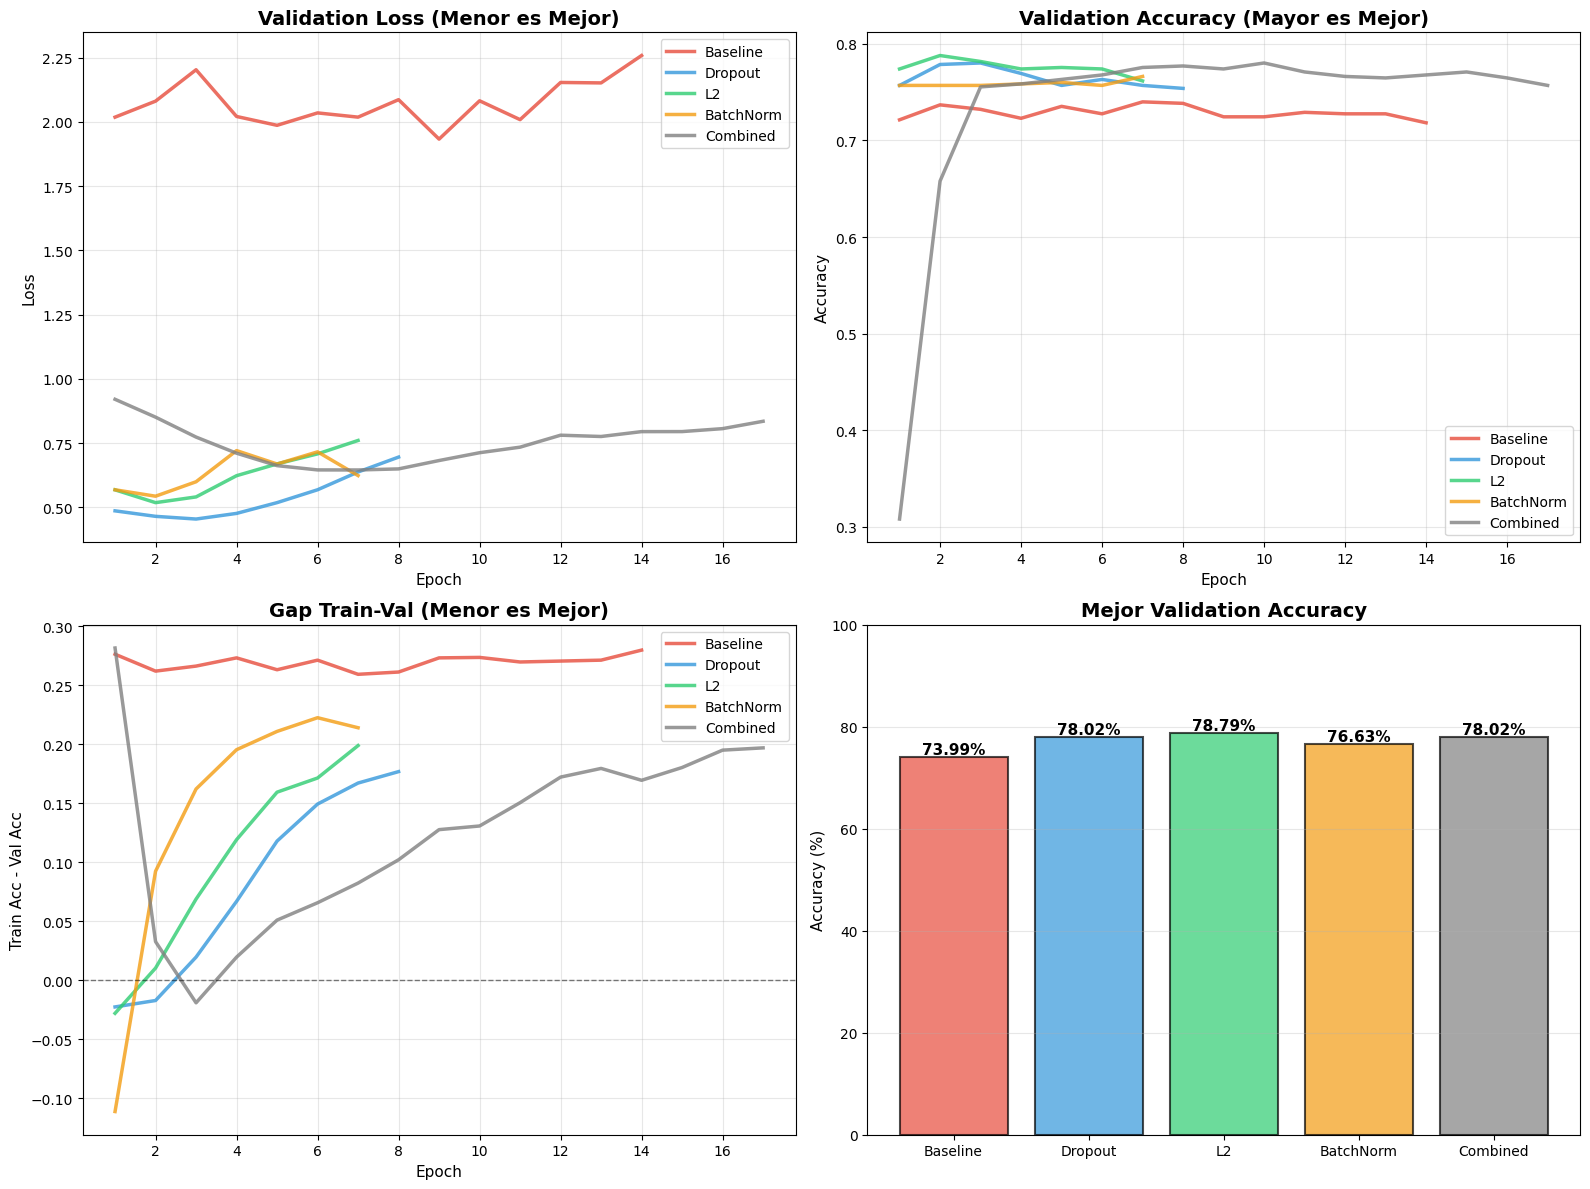


📊 COMPARACIÓN COMPLETA DE TÉCNICAS DE REGULARIZACIÓN

Técnica           Best Val Acc   Final Val Acc        Gap   Min Val Loss
------------------------------------------------------------------------------------------
Baseline                0.7399          0.7183     0.2798         1.9331
Dropout                 0.7802          0.7539     0.1768         0.4541
L2                      0.7879          0.7616     0.1989         0.5179
BatchNorm               0.7663          0.7663     0.2140         0.5430
Combined                0.7802          0.7570     0.1970         0.6451
------------------------------------------------------------------------------------------

🏆 GANADORES:
   • Mejor Accuracy:       L2 (0.7879)
   • Mejor Generalización: Dropout (gap = 0.1768)

💡 INSIGHTS:
   • Dropout: Excelente para reducir overfitting
   • L2: Suaviza pesos, buena generalización
   • BatchNorm: Acelera entrenamiento + regularización implícita


In [90]:
compare_all_techniques(histories_final)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


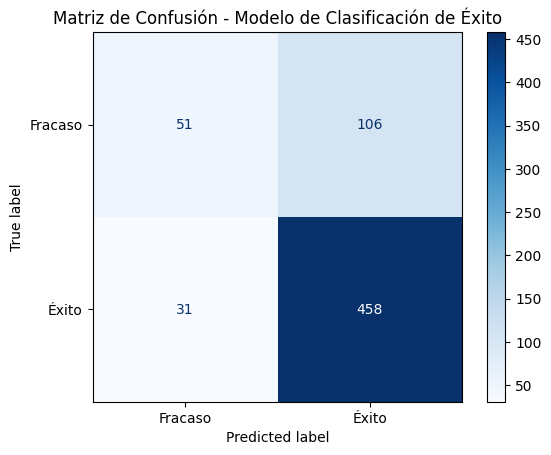

In [96]:

y_pred_prob = l2_model.predict(X_test)

# 2️⃣ Convertir probabilidades en etiquetas binarias (0/1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 3️⃣ Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# 4️⃣ Mostrar matriz con gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fracaso', 'Éxito'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Modelo de Clasificación de Éxito")
plt.show()

# **Predicción de la recaudación**

In [97]:
# Variables de entrada y salida
features = ['budget', 'popularity', 'vote_average', 'runtime', 'main_genre', 'director']
X = df[features]
y = df['revenue']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Modelo de regresión
regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

regressor.fit(X_train, y_train)

# Predicciones
y_pred = regressor.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"R²: {r2:.3f}")


RMSE: 132,107,605
R²: 0.655


In [103]:
metrics = {
    "RMSE": rmse,
    "R2": r2
}

# Guardar en un archivo JSON
with open("../model/regression_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("✅ Métricas guardadas en model/regression_metrics.json")

✅ Métricas guardadas en model/regression_metrics.json


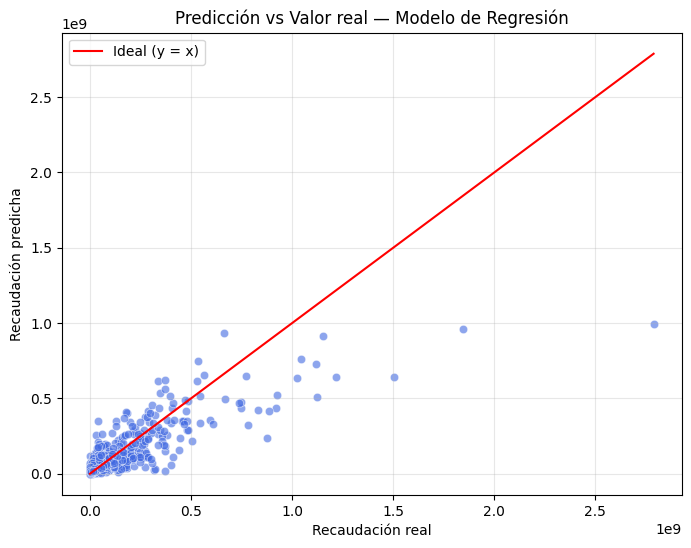

In [99]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue', edgecolor='white')
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal (y = x)')
plt.xlabel("Recaudación real")
plt.ylabel("Recaudación predicha")
plt.title("Predicción vs Valor real — Modelo de Regresión")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [101]:
joblib.dump(regressor, "../model/revenue_regressor.pkl")
print("✅ Modelo de regresión guardado como 'revenue_regressor.pkl'")

✅ Modelo de regresión guardado como 'revenue_regressor.pkl'
